<a href="https://colab.research.google.com/github/imshivs/stock-market-sentiment-analysis/blob/main/Stock_Market_Tweets_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Tweets Sentiment Analysis
Investing has become more accessible to retailer investors in recent years, so it has become more important to understand social sentiment towards businesses and tradable financial assets. The goal of this project is to correctly classify financial tweets as "positive", "negative", or "neutral". We are not looking to see if these sentiments drove historical changes in stock price. However, it would also be interesting to include stock price data or other economic variables such as interest rates in this type of analysis in the future.

In [183]:
import pandas as pd
import numpy as np
import gensim
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
from nltk.tokenize.toktok import ToktokTokenizer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
import nltk
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import matplotlib.pyplot as plt
stop = stopwords.words('english')
stop = r'\b(?:{})\b'.format('|'.join(stop))
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Import & Cleaning
These are the stop words we will use to remove words we don't want feed to our model. Urls and stop words will be removed from text before tokenization and feature reduction steps.

In [184]:
stop

"\\b(?:i|me|my|myself|we|our|ours|ourselves|you|you're|you've|you'll|you'd|your|yours|yourself|yourselves|he|him|his|himself|she|she's|her|hers|herself|it|it's|its|itself|they|them|their|theirs|themselves|what|which|who|whom|this|that|that'll|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|s|t|can|will|just|don|don't|should|should've|now|d|ll|m|o|re|ve|y|ain|aren|aren't|couldn|couldn't|didn|didn't|doesn|doesn't|hadn|hadn't|hasn|hasn't|haven|haven't|isn|isn't|ma|mightn|mightn't|mustn|mustn't|needn|needn't|shan|shan't|shouldn|shouldn't|wasn|wasn't|weren|weren't|won|won't|wouldn|wouldn't)\\b"

I started with a pre-labeled twitter sentiment datset I found on Kaggle, but the predictions using keras weren't very strong for this dataset (40-50% accuracy). This may have been becase the dataset is so small, only 1300 tweets. I decided to look for larger twitter stock-related datastes.

Data source: https://www.kaggle.com/datasets/utkarshxy/stock-markettweets-lexicon-data

In [185]:
data1 = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/tweets_labelled_09042020_16072020.csv", sep=';', header=0))
data1 = data1[["text","sentiment"]]
data1 = data1[data1["sentiment"].notna()]
data1['text'] = data1['text'].str.replace('http\S+|www.\S+', '', case=False)
data1['text'] = data1['text'].str.replace(stop, '')
data1['text'] = data1['text'].str.replace(r'\s+', ' ')
data1

<ipython-input-185-f52e49287e13>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data1['text'] = data1['text'].str.replace('http\S+|www.\S+', '', case=False)
<ipython-input-185-f52e49287e13>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data1['text'] = data1['text'].str.replace(stop, '')
<ipython-input-185-f52e49287e13>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data1['text'] = data1['text'].str.replace(r'\s+', ' ')


,text,sentiment
0,"RT @RobertBeadles: Yo💥 Enter WIN 1,000 Monarch...",positive
1,#SriLanka surcharge fuel removed! ⛽📉 The surch...,negative
2,Net issuance increases fund fiscal programs &g...,positive
3,RT @bentboolean: How much Amazon' traffic serv...,positive
4,$AMD Ryzen 4000 desktop CPUs looking ‘great’ t...,positive
...,...,...
1295,#stocks back recovery room: Fair value: 57€ Fa...,positive
1296,RT @MacroCharts: Breadth – expanding last week...,positive
1297,RT @MawsonResource: Rompas-Rajapalot: A Big Ne...,neutral
1298,$AAPL $QQQ Top may .,positive


The data was collected using the Twitter API. The repository author explains, "The dataset encompasses tweets from various Twitter sources ranging from established media companies such as Bloomberg and CNBC to private traders Antonio Costa (@ACInvestorBlog) and Gnotz (Bull) (@BullTradeFinder) to get a range of different tweets and enough language heterogeneity for models to be able to successfully handle differing syntax".

The author used this dataset in a project using sparse transformer technique to classify tweets and is able to get 87.5% sentiment analysis accuracy using this method (https://neuralmagic.com/blog/classifying-finance-tweets-in-real-time-with-sparse-transformers/). I am not following his tutorial, and instead building simple neural network for this multi-class classification problem.

The sentiments were labeled based on the following mapping prior to my recoding:

sentiments = {
    "LABEL_0": "Bearish",
    "LABEL_1": "Bullish",
    "LABEL_2": "Neutral"
}

Data source: https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment

In [187]:
def my_recode(sentiment):
    if sentiment == 0:
        return "negative"
    if sentiment == 1:
        return "positive"
    else:
        return "neutral"

data2 = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/twitter-financial-news-sentiment_1.csv", header=0))
data3 = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/twitter-financial-news-sentiment_2.csv", header=0))
data4 = pd.concat([data2,data3])
data4['label'] = data4['label'].apply(my_recode)
#remove urls from text
data4['text'] = data4['text'].str.replace('http\S+|www.\S+', '', case=False)
#remove stop words from text
data4['text'] = data4['text'].str.replace(stop, '')
data4['text'] = data4['text'].str.replace(r'\s+', ' ')
data4 = data4.rename(columns={'text': 'text', 'label': 'sentiment'})
data = pd.concat([data1,data4])
data = data4
data

<ipython-input-187-0e8fed5d4f27>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  data4['text'] = data4['text'].str.replace('http\S+|www.\S+', '', case=False)
<ipython-input-187-0e8fed5d4f27>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  data4['text'] = data4['text'].str.replace(stop, '')
<ipython-input-187-0e8fed5d4f27>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  data4['text'] = data4['text'].str.replace(r'\s+', ' ')


,text,sentiment
0,$BYND - JPMorgan reels expectations Beyond Meat,negative
1,$CCL $RCL - Nomura points bookings weakness Ca...,negative
2,"$CX - Cemex cut Credit Suisse, J.P. Morgan wea...",negative
3,$ESS: BTIG Research cuts Neutral,negative
4,$FNKO - Funko slides Piper Jaffray PT cut,negative
...,...,...
2383,Stocks making biggest moves midday: TD Ameritr...,neutral
2384,"Stocks making biggest moves premarket: Fitbit,...",neutral
2385,Stocks making biggest moves premarket: Home De...,neutral
2386,Stocks making biggest moves premarket: TD Amer...,neutral


In [188]:
tweets = np.array(data['text'])
sentiments = np.array(data['sentiment'])

In [191]:
train_size = int(len(data) * 0.6)
test_size = len(data) - train_size

train_tweets, test_tweets = tweets[:train_size], tweets[train_size:len(data)]
train_sentiments, test_sentiments = sentiments[:train_size], sentiments[train_size:len(data)]

## Tokenization
This tokenizer is a simple white-space based method to break each tweet into individual words. In a future version of this project, I'd like to implement stemming or lemmatization with the NLTK package. Lemmatization removes all of the suffixes, prefixes, and morphological changes for each word. Stemming would just output the root word for every word in each tweet. Lemmatization uses dictionary look ups to find relationships between words. For example, The word "better" has "good" as its lemma.

Sources:
https://alvinntnu.github.io/python-notes/nlp/sentiment-analysis-dl.html

https://www.holisticseo.digital/python-seo/nltk/tokenization

In [193]:
tokenizer = ToktokTokenizer()

le = LabelEncoder()
num_classes=3
# tokenize train reviews & encode train labels
tokenized_train = [tokenizer.tokenize(text)
                   for text in train_tweets]
y_tr = le.fit_transform(train_sentiments)
y_tr
y_train = keras.utils.to_categorical(y_tr, num_classes)

# tokenize test reviews & encode test labels
tokenized_test = [tokenizer.tokenize(text)
                   for text in test_tweets]
y_ts = le.fit_transform(test_sentiments)
y_test = keras.utils.to_categorical(y_ts, num_classes)

In [234]:
train_tweets[1]

'$CCL $RCL - Nomura points bookings weakness Carnival Royal Caribbean '

In [235]:
tokenized_train[1]

['$',
 'CCL',
 '$',
 'RCL',
 '-',
 'Nomura',
 'points',
 'bookings',
 'weakness',
 'Carnival',
 'Royal',
 'Caribbean']

## Training Word Embeddings
This is a dimension reduction technique (often used with short-form text) that turns each tweet into a numeric representation of a set number of features. I chose 500 features, so there is an array of 500 numbers that represents each tweet.

Source: https://alvinntnu.github.io/python-notes/nlp/sentiment-analysis-dl.html

In [194]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)

    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.

        for word in words:
            if word in vocabulary:
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [195]:
# build word2vec model
w2v_num_features = 500
w2v_model = gensim.models.Word2Vec(tokenized_train,
                                   vector_size=w2v_num_features, window=150,
                                   min_count=10, sample=1e-3, workers=16)

## takes 5mins

In [196]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=w2v_model,
                                                     num_features=w2v_num_features)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model,
                                                    num_features=w2v_num_features)

# Keras Classifier - Specification and Fitting

In [197]:
def build_classifier():   #one of the parameter for KerasClassifier
    classifier = Sequential() #initialising ANN by defining sequence of layers
    classifier.add(Dense(250, input_shape=(500,), activation='relu'))
    classifier.add(Dense(3, activation='sigmoid'))
    #compiling the ANN
    classifier.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'])
    return classifier

In [203]:
model = KerasClassifier(build_fn = build_classifier,nb_epoch = 10,batch_size=10)
model.fit(avg_wv_train_features, y_train, epochs=1000, batch_size=10,
            shuffle=True, validation_split=0.1)

Epoch 1/1000


<ipython-input-203-95f105d1d605>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = build_classifier,nb_epoch = 10,batch_size=10)


645/645 [==============================] - 3s 3ms/step - loss: 0.4877 - accuracy: 0.6892 - val_loss: 0.6603 - val_accuracy: 0.4972
Epoch 2/1000
645/645 [==============================] - 1s 2ms/step - loss: 0.4738 - accuracy: 0.6962 - val_loss: 0.6772 - val_accuracy: 0.4972
Epoch 3/1000
645/645 [==============================] - 1s 2ms/step - loss: 0.4670 - accuracy: 0.7041 - val_loss: 0.6589 - val_accuracy: 0.4972
Epoch 4/1000
645/645 [==============================] - 1s 2ms/step - loss: 0.4613 - accuracy: 0.7072 - val_loss: 0.6326 - val_accuracy: 0.4972
Epoch 5/1000
645/645 [==============================] - 1s 2ms/step - loss: 0.4579 - accuracy: 0.7085 - val_loss: 0.6116 - val_accuracy: 0.4958
Epoch 6/1000
645/645 [==============================] - 1s 2ms/step - loss: 0.4551 - accuracy: 0.7103 - val_loss: 0.6217 - val_accuracy: 0.4972
Epoch 7/1000
645/645 [==============================] - 1s 2ms/step - loss: 0.4538 - accuracy: 0.7105 - val_loss: 0.6628 - val_accuracy: 0.4972
Epoch

# Performance Metric Functions

In [199]:
# functions from Text Analytics with Python book
def get_metrics(true_labels, predicted_labels):

    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels,
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels,
                                               predicted_labels,
                                               average='weighted'),
                        4))

def display_confusion_matrix(true_labels, predicted_labels, classes=[0,1,2]):

    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels,
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm,
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes],
                                                  codes=level_labels),
                            index=pd.MultiIndex(levels=[['Actual:'], classes],
                                                codes=level_labels))
    print(cm_frame)

def display_classification_report(true_labels, predicted_labels, classes=[0,1,2]):

    report = metrics.classification_report(y_true=true_labels,
                                           y_pred=predicted_labels,
                                           labels=classes)
    print(report)



def display_model_performance_metrics(true_labels, predicted_labels, classes=[0,1,2]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels,classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels,classes=classes)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


## Predictions

In [204]:
y_pred = model.predict(avg_wv_test_features)
predictions = le.inverse_transform(y_pred)

150/150 [==============================] - 0s 1ms/step


View results dataframe as a gut check to spot-check and see if the model's classification make sense. In most cases, the predicted sentiments seem to make sense. Though, the overwhelming majority of sentiments are "neutral".

In [227]:
pd.concat([pd.Series(test_tweets),pd.Series(predictions)],axis=1)

,0,1
0,Boris Johnson Jeremy Corbyn go head--head fina...,neutral
1,Boris Johnson Jeremy Corbyn radically differen...,neutral
2,Boris Johnson Cancels 2020 Tax Cut Businesses:...,neutral
3,Boris Johnson heading clear victory next week’...,neutral
4,Boris Johnson postpones plans cut corporate taxes,neutral
...,...,...
4768,Stocks making biggest moves midday: TD Ameritr...,neutral
4769,"Stocks making biggest moves premarket: Fitbit,...",neutral
4770,Stocks making biggest moves premarket: Home De...,neutral
4771,Stocks making biggest moves premarket: TD Amer...,neutral


# Results
The dataset is unbalanced and negative sentiments are the most common.The model is able to correctly classify negatives 97.5% of the time, neutrals 16% of the time, and positives 5% of the time. Records were most commonly misclassified at negatives. This is interesting because the majority of our training set tweets had a neutral sentiment. There may be more nuance and context needed for classifying positive and neutral tweets. For example, "Tesla' stock falls , extends pullback 22%" in our training set is classied as neutral. Some of the words in this tweet could be percieved as negative sentiments. We're also training the model based on the subjective views of the labeler.

Overall, we're able to achieve an accuracy of 64.76%. This is not as impressive as the 87.5% accuracy achieved by the sparse transformer technique from the blog post we referenced earlier. However, considering that we are working with a very simple neural network and a relatively small dataset, this seems promising. If we had a larger dataset and more balanced classes, perhaps the neural network would be able to perform better. This project helped me understand the importance of creating a diverse training set and the painstaking nature of labeling and preprocessing steps in machine learning projects.

Confusion matrix, without normalization
[[  37  525  112]
 [  13 2860   59]
 [  29  944  194]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

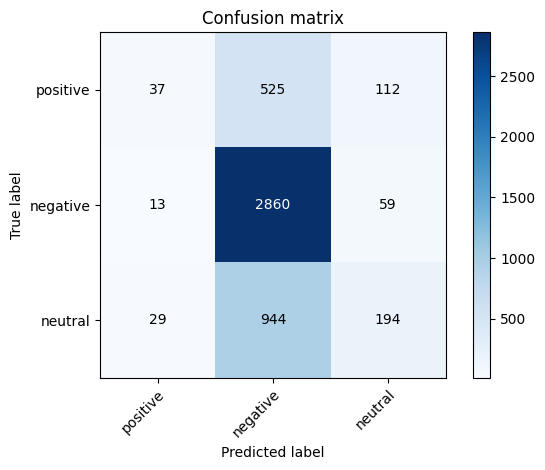

In [213]:
plot_confusion_matrix(test_sentiments, predictions, classes=["positive","negative","neutral"], normalize= False,  title='Confusion matrix')


In [206]:
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions,classes=["positive","negative","neutral"])

Model Performance metrics:
------------------------------
Accuracy: 0.6476
Precision: 0.6019
Recall: 0.6476
F1 Score: 0.5597

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.53      0.17      0.25      1167
    negative       0.47      0.05      0.10       674
     neutral       0.66      0.98      0.79      2932

    accuracy                           0.65      4773
   macro avg       0.55      0.40      0.38      4773
weighted avg       0.60      0.65      0.56      4773


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive negative neutral
Actual: positive        194       29     944
        negative        112       37     525
        neutral          59       13    2860
